# NRWC AI Music Workshop

In [83]:
# Standard library imports
import json
import os
import subprocess
from typing import Dict, List, Optional

# Third-party imports
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import special, stats
from scipy.special import gammaincc
from scipy.stats import chi2, chi2_contingency
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar

# Local application imports
import helper_functions as hf  # Custom helper functions
# Run script to create json file with ordinal column config
ordinal_columns = hf.load_ordinal_columns("save_ordinal_columns.py", "ordinal_cols.json")

# Jupyter Notebook extensions
%load_ext autoreload
%autoreload 2

# File paths (Data loading section could be separated here or in a later part of the notebook)
file_path_1 = 'data/NRWC-quiz_V2.xlsx'
file_path_2 = 'data/nrwc2024-survey_V5.csv'

save_ordinal_columns.py ran successfully.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import the data 

Please note for the Quiz: 
- Replies are not mandatory for all cells - there can be empty cells 
- Every row corresponds to a participant (here called 'Voter')
- There should be 15 participants?

In [111]:
df_quiz = pd.read_excel(file_path_1, sheet_name='Voters', usecols='A:O', skiprows=2) 
df_survey = pd.read_csv(file_path_3)

## Exploratory Data Analysis (EDA)

### Survey

In [85]:
# Check the structure of the data 
df_survey.head()

,id,What is your profession/main occupation?,What is your age?,Gender,"If in-store music is played, I would prefer the music to be human-made rather than AI-generated",I prefer in-store music rather than a silent shopping environment,I prefer highly personalized in-store music,"When facing a choice between maximum privacy and minimum personalization and minimum privacy and maximum personalization, what would you prefer?",I prefer not to share data about myself or my musical taste to companies,Submitted At
0,bzfnpztvni,Student,21,Female,I am neutral,I prefer music,Slightly agree,"moderate privacy, moderate personalization",I slightly agree,"Nov 08, 2024 09:15 am"
1,ibukcyygc6,Student,27,Female,I prefer human-made,I strongly prefer music,Slightly agree,"moderate privacy, moderate personalization",I strongly agree,"Nov 07, 2024 09:33 pm"
2,jpu5gqsbjh,Student,26,Male,I prefer human-made,I strongly prefer music,Agree,"low privacy, high personalization",I slightly agree,"Nov 07, 2024 08:11 pm"
3,juyod7s01l,PhD student,31,Male,I am neutral,I slightly prefer silence,Slightly agree,"moderate privacy, moderate personalization",I agree,"Nov 07, 2024 12:14 pm"
4,p0x1xa6nbu,Academic,57,Male,I am neutral,I slightly prefer music,I am neutral,"maximum privacy, minimum personalization",I am neutral,"Nov 07, 2024 11:31 am"


In [86]:
# Verify data types and missing values 
df_survey.info()
# Get summary statistics 
df_survey.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                                                                                                                                            Non-Null Count  Dtype 
---  ------                                                                                                                                            --------------  ----- 
 0   id                                                                                                                                                42 non-null     object
 1   What is your profession/main occupation?                                                                                                          42 non-null     object
 2   What is your age?                                                                                                                                 42 non-null     int64 
 3   Gender                

,What is your age?
count,42.000000
mean,30.714286
std,11.970056
min,19.000000
25%,21.000000
50%,26.000000
75%,39.000000
max,62.000000


In [87]:
# Check for missing values 
df_survey.isnull().sum()

id                                                                                                                                                  0
What is your profession/main occupation?                                                                                                            0
What is your age?                                                                                                                                   0
Gender                                                                                                                                              0
If in-store music is played, I would prefer the music to be human-made rather than AI-generated                                                     0
I prefer in-store music rather than a silent shopping environment                                                                                   0
I prefer highly personalized in-store music                                                         

### Quiz 

In [88]:
df_quiz.head()

,Date,Session,Voter,:,:.1,:.2,:.3,:.4,:.5,:.6,:.7,:.8,:.9,:.10,:.11
0,2024-11-05,1,1,Åhlens,Naturkompaniet,XS Leker,Kappahl,Stadium,Cubus,Naturkompaniet,NaN,NaN,NaN,NaN,NaN
1,2024-11-05,2,2,Naturkompaniet,XS Leker,Stadium,Åhlens,Cubus,Kappahl,Stadium,Kappahl,XS Leker,Stadium,Naturkompaniet,Kappahl
2,2024-11-05,2,3,Kappahl,NaN,Stadium,Cubus,Åhlens,XS Leker,Stadium,Cubus,Kappahl,XS Leker,Åhlens,Stadium
3,2024-11-05,2,4,Kappahl,Naturkompaniet,XS Leker,Stadium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-06,3,5,Åhlens,Kappahl,Åhlens,Åhlens,Naturkompaniet,XS Leker,Cubus,Cubus,Naturkompaniet,Åhlens,Naturkompaniet,Stadium


In [89]:
df_quiz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     18 non-null     object
 1   Session  18 non-null     int64 
 2   Voter    18 non-null     int64 
 3   :        18 non-null     object
 4   :.1      17 non-null     object
 5   :.2      18 non-null     object
 6   :.3      18 non-null     object
 7   :.4      17 non-null     object
 8   :.5      17 non-null     object
 9   :.6      16 non-null     object
 10  :.7      16 non-null     object
 11  :.8      16 non-null     object
 12  :.9      16 non-null     object
 13  :.10     16 non-null     object
 14  :.11     16 non-null     object
dtypes: int64(2), object(13)
memory usage: 2.2+ KB


In [90]:
# Missing values 
print(df_quiz.isnull().sum())

# Descriptive statistics for question columns 
category_stats = df_quiz[df_quiz.columns[3:]].describe(include='object')
# Add missing values count row to the descriptive statistics df
# Missing values per column
missing_counts = df_quiz[df_quiz.columns[3:]].isnull().sum()
# Add the missing values count as a new row to the descriptive statistics DataFrame
category_stats.loc['NaN'] = missing_counts
category_stats

Date       0
Session    0
Voter      0
:          0
:.1        1
:.2        0
:.3        0
:.4        1
:.5        1
:.6        2
:.7        2
:.8        2
:.9        2
:.10       2
:.11       2
dtype: int64


,:,:.1,:.2,:.3,:.4,:.5,:.6,:.7,:.8,:.9,:.10,:.11
count,18,17,18,18,17,17,16,16,16,16,16,16
unique,5,5,6,4,5,4,5,4,6,6,5,5
top,Åhlens,Kappahl,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Åhlens,Åhlens,Naturkompaniet,Stadium
freq,11,6,11,7,12,13,6,8,4,6,7,7
NaN,0,1,0,0,1,1,2,2,2,2,2,2


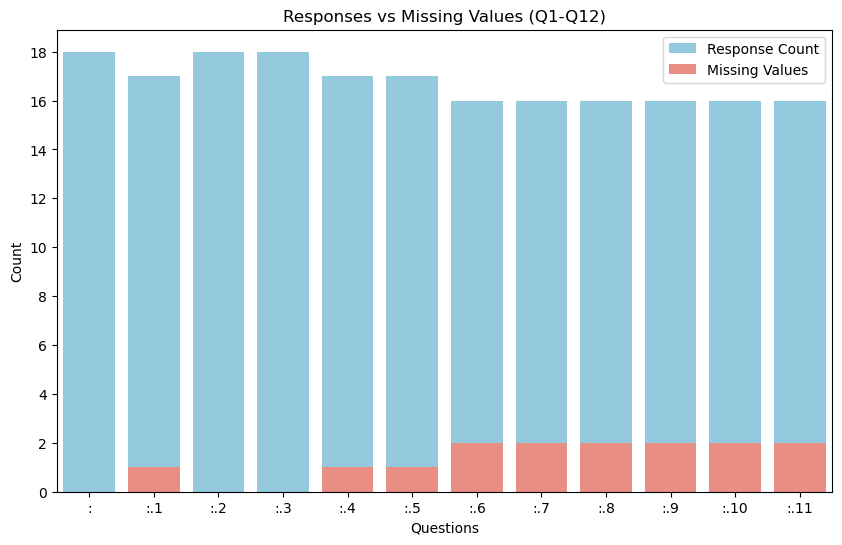

In [91]:
# Plot response counts versus missing values
plt.figure(figsize=(10, 6))
ax = plt.gca()  
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) # Make sure y axis has only integers, since it shows counts  
sns.barplot(x=category_stats.columns, y=category_stats.loc['count'], color='skyblue', label='Response Count')
sns.barplot(x=missing_counts.index, y=missing_counts.values, color='salmon', label='Missing Values')
plt.title('Responses vs Missing Values (Q1-Q12)')
plt.xlabel('Questions')
plt.ylabel('Count')
plt.legend()
plt.show()

## Data cleaning 

### Survey 

In [92]:
# Rename columns (names are too long) 
new_column_names = ['Id', 'Occupation', 'Age', 'Gender', 'Human_or_AI_music', 'Music_or_silence', 'Personalized_music', 'Privacy_vs_personalization', 'Sharing_data', 'Time']
df_survey.columns = new_column_names
df_survey.head(3)

,Id,Occupation,Age,Gender,Human_or_AI_music,Music_or_silence,Personalized_music,Privacy_vs_personalization,Sharing_data,Time
0,bzfnpztvni,Student,21,Female,I am neutral,I prefer music,Slightly agree,"moderate privacy, moderate personalization",I slightly agree,"Nov 08, 2024 09:15 am"
1,ibukcyygc6,Student,27,Female,I prefer human-made,I strongly prefer music,Slightly agree,"moderate privacy, moderate personalization",I strongly agree,"Nov 07, 2024 09:33 pm"
2,jpu5gqsbjh,Student,26,Male,I prefer human-made,I strongly prefer music,Agree,"low privacy, high personalization",I slightly agree,"Nov 07, 2024 08:11 pm"


In [93]:
df_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Id                          42 non-null     object
 1   Occupation                  42 non-null     object
 2   Age                         42 non-null     int64 
 3   Gender                      42 non-null     object
 4   Human_or_AI_music           42 non-null     object
 5   Music_or_silence            42 non-null     object
 6   Personalized_music          42 non-null     object
 7   Privacy_vs_personalization  42 non-null     object
 8   Sharing_data                42 non-null     object
 9   Time                        42 non-null     object
dtypes: int64(1), object(9)
memory usage: 3.4+ KB


In [94]:
# Fix data types for columns 
df_survey['Occupation'] = df_survey['Occupation'].astype('string')
df_survey['Time'] = pd.to_datetime(df_survey['Time'], format='%b %d, %Y %I:%M %p')
# Convert 'Age' to numeric, setting non-numeric values as NaN
df_survey['Age'] = pd.to_numeric(df_survey['Age'], errors='coerce')

In [95]:
# Convert to ordinal data
df_survey = df_survey.apply(lambda col: hf.convert_to_categorical(col, ordinal_columns) if col.name in ordinal_columns else col)
df_survey.info()

# Corresponding loop implementation
#for column, categories in ordinal_columns.items():
#    if column in df_survey.columns:
#        # Convert the column to a categorical type with the specified categories
#        df_survey[column] = pd.Categorical(df_survey[column], categories=categories, ordered=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Id                          42 non-null     object        
 1   Occupation                  42 non-null     string        
 2   Age                         42 non-null     int64         
 3   Gender                      42 non-null     object        
 4   Human_or_AI_music           42 non-null     category      
 5   Music_or_silence            42 non-null     category      
 6   Personalized_music          42 non-null     category      
 7   Privacy_vs_personalization  42 non-null     category      
 8   Sharing_data                42 non-null     category      
 9   Time                        42 non-null     datetime64[ns]
dtypes: category(5), datetime64[ns](1), int64(1), object(2), string(1)
memory usage: 3.7+ KB


In [96]:
# Check for null values 
df_survey.isna().sum()

Id                            0
Occupation                    0
Age                           0
Gender                        0
Human_or_AI_music             0
Music_or_silence              0
Personalized_music            0
Privacy_vs_personalization    0
Sharing_data                  0
Time                          0
dtype: int64

In [97]:
# There is a NaN in the Age column, remove this line 
#df_survey.isna().sum() # One missing value in Age column 
#df_survey.dropna(subset=['Age'], inplace=True)
#df_survey.isna().sum()

In [107]:
# Create a mask for rows to keep, if any ids need to be removed 
#mask = (df_survey['id'] != 'fi3trcsuvu') & (df_survey['id'] != 'xerby9dknu') &  (df_survey['id'] != '3cshmhe4pk') 
#df_survey_filtered = df_survey[mask]
df_survey_filtered = df_survey
print('Total number of participants: ', df_survey_filtered['id'].nunique()) 

Total number of participants:  42


### Quiz 

In [98]:
# Rename columns from the 3rd column onward to 'Q1' to 'Q12'
new_column_names = {df_quiz.columns[i]: f"Q{i - 2}" for i in range(3, 15)}  
df_quiz.rename(columns=new_column_names, inplace=True)
df_quiz.head(3)

,Date,Session,Voter,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
0,2024-11-05,1,1,Åhlens,Naturkompaniet,XS Leker,Kappahl,Stadium,Cubus,Naturkompaniet,NaN,NaN,NaN,NaN,NaN
1,2024-11-05,2,2,Naturkompaniet,XS Leker,Stadium,Åhlens,Cubus,Kappahl,Stadium,Kappahl,XS Leker,Stadium,Naturkompaniet,Kappahl
2,2024-11-05,2,3,Kappahl,NaN,Stadium,Cubus,Åhlens,XS Leker,Stadium,Cubus,Kappahl,XS Leker,Åhlens,Stadium


In [99]:
df_quiz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     18 non-null     object
 1   Session  18 non-null     int64 
 2   Voter    18 non-null     int64 
 3   Q1       18 non-null     object
 4   Q2       17 non-null     object
 5   Q3       18 non-null     object
 6   Q4       18 non-null     object
 7   Q5       17 non-null     object
 8   Q6       17 non-null     object
 9   Q7       16 non-null     object
 10  Q8       16 non-null     object
 11  Q9       16 non-null     object
 12  Q10      16 non-null     object
 13  Q11      16 non-null     object
 14  Q12      16 non-null     object
dtypes: int64(2), object(13)
memory usage: 2.2+ KB


In [100]:
# Fix data types for columns 
df_quiz['Date'] = pd.to_datetime(df_quiz['Date'])
cols_to_convert = list(new_column_names.values())
# Convert these columns to categorical 
df_quiz[cols_to_convert] = df_quiz[cols_to_convert].apply(lambda x: x.astype('category'))
df_quiz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     18 non-null     datetime64[ns]
 1   Session  18 non-null     int64         
 2   Voter    18 non-null     int64         
 3   Q1       18 non-null     category      
 4   Q2       17 non-null     category      
 5   Q3       18 non-null     category      
 6   Q4       18 non-null     category      
 7   Q5       17 non-null     category      
 8   Q6       17 non-null     category      
 9   Q7       16 non-null     category      
 10  Q8       16 non-null     category      
 11  Q9       16 non-null     category      
 12  Q10      16 non-null     category      
 13  Q11      16 non-null     category      
 14  Q12      16 non-null     category      
dtypes: category(12), datetime64[ns](1), int64(2)
memory usage: 3.2 KB


In [101]:
# As we saw in the plot 'Responses vs Missing Values (Q1-Q12)', there is some missing data, but for now we keep these rows 
# Suitable null value approach depends on type of analysis performed later
df_quiz.isna().sum()

Date       0
Session    0
Voter      0
Q1         0
Q2         1
Q3         0
Q4         0
Q5         1
Q6         1
Q7         2
Q8         2
Q9         2
Q10        2
Q11        2
Q12        2
dtype: int64

In [109]:
# If filtering on day is required 
#mask_date = df_quiz['Date'] == '2024-11-06'
filtered_df_date = df_quiz
#filtered_df_date = df_quiz[mask_date]
filtered_df_date

,Date,Session,Voter,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
0,2024-11-05,1,1,Åhlens,Naturkompaniet,XS Leker,Kappahl,Stadium,Cubus,Naturkompaniet,NaN,NaN,NaN,NaN,NaN
1,2024-11-05,2,2,Naturkompaniet,XS Leker,Stadium,Åhlens,Cubus,Kappahl,Stadium,Kappahl,XS Leker,Stadium,Naturkompaniet,Kappahl
2,2024-11-05,2,3,Kappahl,NaN,Stadium,Cubus,Åhlens,XS Leker,Stadium,Cubus,Kappahl,XS Leker,Åhlens,Stadium
3,2024-11-05,2,4,Kappahl,Naturkompaniet,XS Leker,Stadium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-06,3,5,Åhlens,Kappahl,Åhlens,Åhlens,Naturkompaniet,XS Leker,Cubus,Cubus,Naturkompaniet,Åhlens,Naturkompaniet,Stadium
5,2024-11-06,3,6,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,XS Leker,Åhlens,Cubus,Naturkompaniet,Kappahl,Stadium
6,2024-11-06,3,7,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Naturkompaniet,Åhlens,Åhlens,Kappahl
7,2024-11-06,3,8,Åhlens,Cubus,Kappahl,Kappahl,Naturkompaniet,XS Leker,Cubus,XS Leker,Kappahl,Åhlens,Naturkompaniet,Stadium
8,2024-11-06,3,9,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Åhlens,Naturkompaniet,Kappahl,Stadium
9,2024-11-06,3,10,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,Åhlens,XS Leker,Åhlens,Stadium,Cubus,Naturkompaniet,Kappahl


## Feature engineering
### Survey

In [112]:
# Consider encoding categorical variables (one-hot or label encoding for example). 

### Quiz

In [113]:
# Consider encoding categorical variables (one-hot or label encoding for example). 

## Data analysis 

### Survey

In [ ]:
# Perform statistical analysis of this data 
# Separate tests per question

### Quiz

## Results and visualization

### Survey

In [105]:
columns_to_plot = df_survey_filtered.columns[4:9] 
#df_survey_filtered[columns_to_plot]

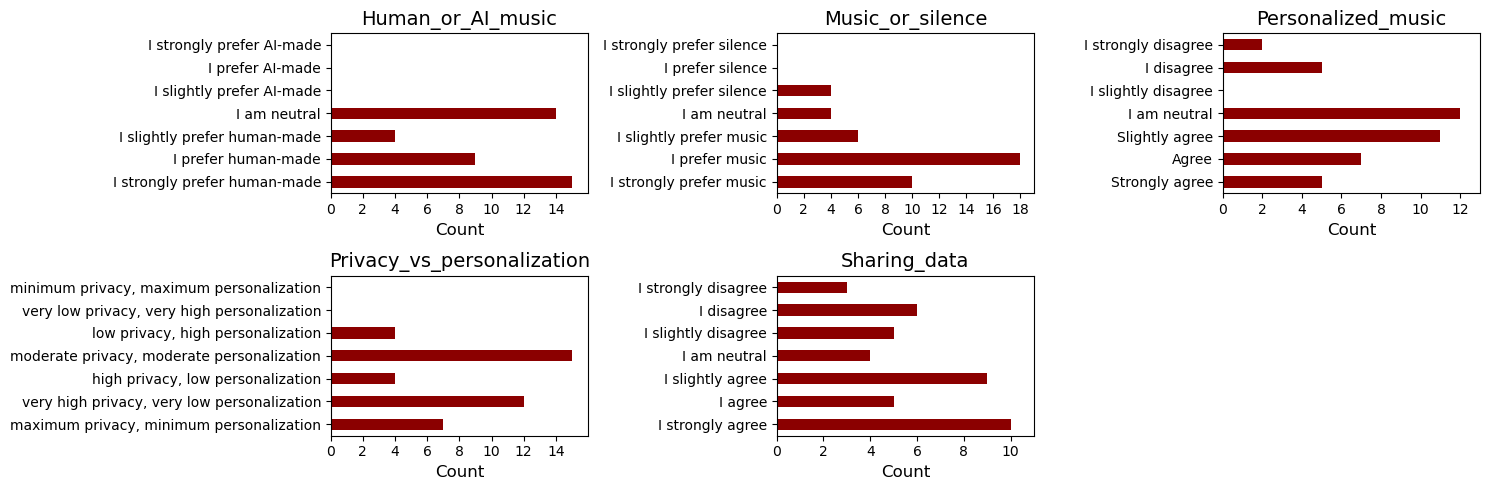

In [106]:
if not os.path.exists('plots/survey'):
    os.makedirs('plots/survey')

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))  # Adjust figsize as needed

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over columns and plot in separate subplots
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    #value_counts = df_survey_filtered[col].value_counts().sort_values(ascending=True)
    value_counts = df_survey_filtered[col].value_counts().sort_index()  # sort_index to maintain the categorical order
    value_counts.plot(kind='barh', ax=ax, color='darkred')

    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.set_title(f'{col}', fontsize=14)
    ax.set_xticks(range(0, int(value_counts.max()) + 1, 2))
    ax.set_xlim(0, int(value_counts.max()) + 1)

# Remove any extra subplots (if necessary)
for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
# Save the figure
plt.savefig('plots/survey/survey_results.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

### Quiz 

In [ ]:
# Define the correct answers
correct_answers_dict = {
    'Q1': 'Åhlens image',
    'Q2': 'Stadium image',
    'Q3': 'Kappahl image',
    'Q4': 'Cubus image',
    'Q5': 'Naturkompaniet image',
    'Q6': 'XS Leker image',
    'Q7': 'Stadium sound',
    'Q8': 'XS Leker sound',
    'Q9': 'Kappahl sound',
    'Q10': 'Cubus sound',
    'Q11': 'Naturkompaniet sound',
    'Q12': 'Åhlens sound'
}
  
# Define a consistent color palette using the colorblind palette
colorblind_palette = sns.color_palette("colorblind", n_colors=len(df.columns[3:].unique()))

# Create a mapping of each store category to a color
unique_categories = df[df.columns[3:]].melt()['value'].dropna().unique() 
color_map = {category: colorblind_palette[i] for i, category in enumerate(unique_categories)}

def ensure_directory(directory):
    """Create directory if it doesn't exist"""
    if not os.path.exists(directory):
        os.makedirs(directory)

def plot_and_save_questions(df, title, output_dir='plots/quiz'):
    # Create directory if it doesn't exist
    ensure_directory(output_dir)
    
    # Create main figure
    fig = plt.figure(figsize=(15, 8))
    # Count non-null values in each column and pick maximum 
    max_count = df.count().max() + 1  # Set max count for x-axis
    
    # Store individual plot data
    individual_plots = []
    
    for i, col in enumerate(df.columns, 1):
        # Create subplot in main figure
        ax = plt.subplot(3, 2, i)
        # Count occurrences of each response
        counts = df[col].value_counts()
        # Create a bar plot using counts
        counts = counts.reindex(unique_categories, fill_value=0)
        counts.plot(kind='barh', ax=ax, color=[color_map[category] for category in counts.index])
        
        subplot_title = f"{col}: {correct_answers_dict[col]}"
        plt.title(subplot_title, wrap=True, fontsize=14)  # Increased subplot title size
        plt.xlabel("Count", fontsize=12)  # Increased x-label size
        plt.ylabel("")
        ax.set_xlim(0, max_count)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # Increase tick label sizes
        ax.tick_params(axis='both', labelsize=12)
        
        # Increase legend font size
        #legend = ax.legend(fontsize=12)
        #legend.set_title("Response", prop={'size': 12})
        
        # Save individual subplot
        individual_fig = plt.figure(figsize=(8, 5))
        individual_ax = individual_fig.add_subplot(111)
        counts.plot(kind='barh', ax=individual_ax, color=[color_map[category] for category in counts.index])
        individual_ax.set_title(subplot_title, wrap=True, fontsize=14)  # Increased individual plot title size
        individual_ax.set_xlabel("Count", fontsize=12)  # Increased individual plot x-label size
        individual_ax.set_ylabel("")
        individual_ax.set_xlim(0, max_count)
        individual_ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # Increase tick label sizes for individual plots
        individual_ax.tick_params(axis='both', labelsize=12)
               
        # Save individual plot
        filename = f"{output_dir}/{col.lower()}_plot.png"
        individual_fig.tight_layout()
        individual_fig.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(individual_fig)
        
    # Finish and save main figure
    plt.figure(fig.number)
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=0.95)  # Increased main title size and adjusted position
    plt.subplots_adjust(top=0.9)
    
    # Save complete figure
    main_filename = f"{output_dir}/subplots_{title.lower().replace(' ', '_').replace(':', '')}.png"
    plt.savefig(main_filename, dpi=300, bbox_inches='tight')
    plt.show()
  
# Plot and save Q1-Q6
df_images = df[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]
plot_and_save_questions(df_images, "Images_Response_Counts_Q1-Q6")

# Plot and save Q7-Q12
df_sounds = df[['Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']]
plot_and_save_questions(df_sounds, "Sounds_Response_Counts_Q7-Q12")

print("All plots have been saved in the 'plots' directory!")

In [ ]:
def plot_stacked_bar(df_subset, title, label_dict=correct_answers_dict, output_dir='plots/quiz'):
    # Create directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Calculate value counts for each question and fill NaNs with 0
    response_counts = df_subset.apply(pd.Series.value_counts).fillna(0).T
    response_counts = response_counts.reindex(columns=unique_categories, fill_value=0)
    
    # Create plot
    response_counts.plot(kind='bar', stacked=True, ax=ax, color=color_map.values())
    
    # Set title with larger font
    plt.title(title, fontsize=16, pad=20)
    
    # Set axis labels with larger font
    plt.xlabel("Questions", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    
    # Set x-axis labels combining question number and description
    x_labels = [f"{col}: {label_dict[col]}" for col in df_subset.columns]
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)  # Increased tick label size
    
    # Increase y-axis tick label size
    ax.tick_params(axis='y', labelsize=12)
    
    plt.ylim(0, response_counts.sum(axis=1).max() + 1)  # Set y-axis limit
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Only show integer ticks
    
    # Set legend with larger font
    plt.legend(title="Response", loc='upper right', fontsize=12)  # Increase legend text size
    ax.get_legend().set_title("Response", prop={'size': 14})  # Increase legend title size
    
    # Adjust layout and save
    plt.tight_layout()
    filename = f"{output_dir}/stacked_{title.lower().replace(' ', '_').replace(':', '')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

# Plot Q1-Q6
df_images = df[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]
plot_stacked_bar(df_images, "Images: Response Counts (Q1-Q6)")

# Plot Q7-Q12
df_sounds = df[['Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']]
plot_stacked_bar(df_sounds, "Sounds: Response Counts (Q7-Q12)")

In [ ]:
# Define the correct answers
correct_answers = ['Åhlens', 'Stadium', 'Kappahl', 'Cubus', 'Naturkompaniet', 'XS Leker', 
                   'Stadium', 'XS Leker', 'Kappahl', 'Cubus', 'Naturkompaniet', 'Åhlens'
]
# Create a copy of the DataFrame to hold correct/incorrect responses
df_correct = df.copy()
df_correct

In [ ]:
# Replace answers with 1 for correct and 0 for incorrect
for i in range(12):  # For Q1 to Q12
    # F-string syntax to dynamically create new column names 
    df_correct[f'Q{i+1}'] = df_correct[f'Q{i+1}'].apply(lambda x: 1 if x == correct_answers[i] else 0)

df_correct

In [ ]:
question_df = df_correct[['Q' + str(i) for i in range(1, 13)]]
question_df

In [ ]:
# Calculate total correct answers per question
total_correct_per_question = question_df.sum(axis=0)
print("Correct answers per question: ")
total_correct_per_question

In [ ]:
# Calculate total correct answers per participant
total_correct_per_participant = question_df.sum(axis=1)
print("Correct answers per participant: ")
total_correct_per_participant

In [ ]:
question_df

In [ ]:
print("\nSuccess rate for each question:")
print(question_df.mean() * 100)  # Percentage correct for each question

In [ ]:
# Calculate total correct for images versus sounds 
# Collapse correct for Q1-Q6
#question_df[['Q' + str(i) for i in range(1, 7)]].sum(axis=0)
# Collapse correct for Q7-Q12
#question_df[['Q' + str(i) for i in range(7, 13)]].sum(axis=0)
#question_df[['Q' + str(i) for i in range(7, 13)]].sum(axis=0)#.sum()

In [ ]:
def plot_correct_answers(total_correct_per_question, correct_answers_dict, output_dir='plots/quiz'):
    # Create directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
      
    # Convert Series to DataFrame and rename columns
    correct_answers_df = total_correct_per_question.reset_index()
    correct_answers_df.columns = ['Questions', 'CorrectAnswers']
    correct_answers_df = correct_answers_df.sort_values(by='CorrectAnswers', ascending=True)
    
    # Create detailed labels combining question number and description
    detailed_labels = [f"{q} : {correct_answers_dict[q]}" for q in correct_answers_df['Questions']]
    
    # Define colors based on question groups (images vs sounds)
    colors = ['lightblue' if q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6'] else 'darkblue' 
              for q in correct_answers_df['Questions']]
    
    # Create figure with adjusted size to accommodate longer labels
    plt.figure(figsize=(12, 8))
    
    # Create horizontal bar plot
    plt.barh(range(len(detailed_labels)), correct_answers_df['CorrectAnswers'], color=colors)
    
    # Set the y-tick positions and labels
    plt.yticks(range(len(detailed_labels)), detailed_labels)
    
    plt.title('Correct Answers per Question', fontsize=16)
    plt.xlabel('Number of Correct Answers', fontsize=12)
    plt.ylabel('Question', fontsize=12)
    
    # Set x-axis ticks to integers
    plt.xticks(range(0, correct_answers_df['CorrectAnswers'].max() + 2))
    
    # Add legend
    legend_handles = [
        patches.Patch(color='lightblue', label='Images (Q1-Q6)'),
        patches.Patch(color='darkblue', label='Sounds (Q7-Q12)')
    ]
    plt.legend(handles=legend_handles, title='Question Groups', loc='upper right')
    
    # Adjust layout and save
    plt.tight_layout()
    filename = f"{output_dir}/corrects.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()


plot_correct_answers(total_correct_per_question, correct_answers_dict)

## Save and export results 

### Survey

### Quiz

Calculate number of correct replies per question 

#### Omnibus testing for images resp sounds 
Answers the question: are there significant differences in the difficulty level of the questions?

- Null Hypothesis: All questions have the same proportion of correct (positive) responses.
- Alternative Hypothesis: At least one question differs from the others in terms of the proportion of correct responses.


The Q statistic measures the overall variability in the proportions of positive responses across the groups.
A larger Q statistic indicates greater variability. 

Please note that although the data is coded as right or wrong, the actual ratio is not really 50%. Correct option is only 1/6! In short, the 1:5 ratio of correct to incorrect options doesn’t impact the binary setup of Cochran’s Q test but does affect the baseline expectation for correct answers if guessing is assumed. You can use Cochran’s Q to explore consistency across questions, and if needed, conduct additional analyses to examine how actual correctness rates align with guessing probability. If one wants to directly test whether the observed proportion of correct answers differs from random guessing across all questions, you might also consider a binomial test or chi-square goodness-of-fit test for each question individually. This would check whether the proportion of correct answers per question differs significantly from 16.67%, which represents random guessing. 


In [ ]:
question_df
#question_df[['Q' + str(i) for i in range(7, 13)]]

In [ ]:
# if these are different it is more likely there is a sig difference
question_df.mean()

In [ ]:
def perform_cochran_q_test(data):
    """
    Performs Cochran's Q test on the given data.

    Args:
        data (pandas.DataFrame): The DataFrame containing binary (0 or 1) data to be analyzed.

    Returns:
        None
    """

    # Ensure data is binary
    if not np.array_equal(data.values, data.values.astype(bool)):
        raise ValueError("Data must be binary (0 or 1) for Cochran's Q test.")

    # Perform Cochran's Q test directly on the values (no transpose needed)
    results = cochrans_q(data.values)
    q_statistic = results.statistic
    p_value = results.pvalue

    # Output results
    print(f"Cochran's Q Statistic: {q_statistic}")
    print(f"P-value: {p_value}")

    # Interpret the results
    if p_value < 0.05:
        print("Significant differences among the questions.")
    else:
        print("No significant differences among the questions.")

# Test all the data 
print('Testing all the questions regardless of image and sound condition.')
perform_cochran_q_test(question_df)
print('- - - - - - - - - - ')

# Test only image data 
print('Testing image conditions.')
perform_cochran_q_test(question_df[['Q' + str(i) for i in range(1, 7)]]) # Change everywhere else so that this is the standard syntax
print('- - - - - - - - - - ')

# Test only sound data 
print('Testing sound conditions.')
perform_cochran_q_test(question_df[['Q' + str(i) for i in range(7, 13)]]) 

In [ ]:
# Just to verify that crochan works, this should be significant
"""
myDf = pd.read_csv('FilmPreferences2123.csv')
myDf.head()
selData = myDf[['munt', 'movies', 'tuschin', 'arena']]
selData.head()
from statsmodels.stats.contingency_tables import cochrans_q
print(cochrans_q(selData))
# Should give 
#df          3
#pvalue      0.00022763307854354147
#statistic   19.384615384615383
"""

#### Post hoc tests 
If significant results, continue with multiple comparison tests 


In [ ]:
def add_significance_stars(p_value):
    """Add significance stars based on p-value."""
    if pd.isna(p_value):
        return ''
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    return ''

def format_p_value(p_value):
    """Format p-value with stars."""
    if pd.isna(p_value):
        return ''
    stars = add_significance_stars(p_value)
    if p_value < 0.001:
        return f"<0.001{stars}"
    return f"{p_value:.4f}{stars}"

def perform_pairwise_mcnemar(df):
    """
    Perform pairwise McNemar tests between all columns in the dataframe.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing binary (0/1) responses
    
    Returns:
    pandas.DataFrame: Matrix of formatted p-values from McNemar tests with significance stars
    pandas.DataFrame: Matrix of test statistics
    """
    columns = df.columns
    n_cols = len(columns)
    
    # Initialize results matrices
    p_values_raw = pd.DataFrame(np.nan, index=columns, columns=columns)
    p_values_formatted = pd.DataFrame('', index=columns, columns=columns)
    test_stats = pd.DataFrame(np.nan, index=columns, columns=columns)
    
    # Perform McNemar test for each pair of columns
    for i in range(n_cols):
        for j in range(i+1, n_cols):
            col1 = columns[i]
            col2 = columns[j]
            
            # Create contingency table
            contingency = pd.crosstab(df[col1], df[col2])
            
            # Check if we have enough unique values for McNemar test
            if contingency.shape != (2, 2):
                print(f"Warning: Cannot compute McNemar test for {col1} vs {col2} - insufficient variation in responses")
                continue
                
            try:
                # Perform McNemar test
                result = mcnemar(contingency, exact=True)
                
                # Store raw p-values for both directions
                p_values_raw.loc[col1, col2] = result.pvalue
                p_values_raw.loc[col2, col1] = result.pvalue
                
                # Store formatted p-values with stars for both directions
                formatted_p = format_p_value(result.pvalue)
                p_values_formatted.loc[col1, col2] = formatted_p
                p_values_formatted.loc[col2, col1] = formatted_p
                
                # Store test statistics for both directions
                test_stats.loc[col1, col2] = result.statistic
                test_stats.loc[col2, col1] = result.statistic
                
            except Exception as e:
                print(f"Warning: Could not compute McNemar test for {col1} vs {col2} - {str(e)}")
    
    return p_values_raw, p_values_formatted, test_stats

In [ ]:
"""
# Create test dataset with known differences to test 
n_samples = 100
np.random.seed(42)

test_df = pd.DataFrame({
    'A': np.random.binomial(1, 0.5, n_samples),  # 50% success rate
    'B': np.random.binomial(1, 0.5, n_samples),  # 50% success rate
    'C': np.random.binomial(1, 0.8, n_samples),  # 80% success rate
    'D': np.random.binomial(1, 0.2, n_samples)   # 20% success rate
})

# Make B dependent on A but with some changes
test_df['B'] = test_df['A'].copy()
flip_indices = np.random.choice(n_samples, 20, replace=False)
test_df.loc[flip_indices, 'B'] = 1 - test_df.loc[flip_indices, 'B']

print("Sample sizes and success rates:")
print(test_df.mean().round(3))
"""

In [ ]:
print("\nMean values per column:")
print(question_df.mean())
p_values_raw, p_values_formatted, test_stats = perform_pairwise_mcnemar(question_df)

print("\nMcNemar Test P-values (with significance stars):")
print(p_values_formatted)
print("* p < 0.05, ** p < 0.01, *** p < 0.001")

print("\nMcNemar Test Statistics:")
print(test_stats)

In [ ]:
# Probably only makes sense to compare within sound and image categories 

# Q1 and Q7, 9, 10, 12
# Q2 and Q6
# Q3 and Q7, Q9, Q10, Q12
# Q4 and Q10
# Q5 and Q7, Q9, Q10, Q12 
# Q6 and Q2, Q7, Q9, Q10, Q12 
# Q7 and 3,5,6, .....

Reporting a McNemar test: 
A McNemar's test was conducted to compare the proportions of correct responses between the two groups. The results indicated a significant difference, χ²(1) = [Chi-square value], p = [p-value]. The odds ratio was [odds ratio], indicating that the odds of [event] were [times] higher in Group A compared to Group B.

# To be sure, also conduct a chi-square test for each question, to see if it is likely that the results are by chance. 

In [ ]:
# Here we need the actual data, not coded by correct or incorrect 
df.head()
#df['Q1']

In [ ]:
# Test data 
"""
# Set a seed for reproducibility
np.random.seed(42)

# Number of participants
num_participants = 100

# Create a DataFrame with 12 questions
data = {
    'Q1': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q2': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.5]),  # Bias towards 'F'
    'Q3': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q4': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q5': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q6': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q7': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q8': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q9': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q10': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q11': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants),
    'Q12': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=num_participants)
}

df_test_chisquare = pd.DataFrame(data)
df_test_chisquare
"""

In [ ]:
def perform_chi2_test(df, column_name):
    """
    Performs a Chi-Square Goodness of Fit test on the specified column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to test.

    Returns:
        None
    """

    observed_frequencies = df[column_name].value_counts().values
    total_observations = len(df)
    num_categories = len(observed_frequencies)
    expected_frequency = total_observations / num_categories
    expected_frequencies = [expected_frequency] * num_categories

    chi2, p_value, dof, _ = chi2_contingency([observed_frequencies, expected_frequencies])

    print(f"Chi-Square Test for {column_name}")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")

    if p_value < 0.05:
        print(f"******Significant difference detected for {column_name}.******")
    else:
        print(f"No significant difference detected for {column_name}.")

for col in df.columns[3:]:  # Assuming columns Q1 to Q12 start at index 3
    print('\n')
    perform_chi2_test(df, col)

# Old code below

## For testing, generate random numbers if there are n participants 

In [ ]:
# Define number of participants 
# This can also be used later for power calculations 
participants = hf.get_user_input()
print(f"The number of participants is: {participants}")

In [ ]:
# Define columns and create an empty DataFrame
columns = ['A', 'B', 'C', 'D', 'E', 'F']  # Answers for each question
index = [f'Q{i+1}' for i in range(6)]  # Questions Q1 to Q6
df = pd.DataFrame(columns=columns, index=index)
#hf.input_data(index, columns)
df.loc['Q1'] = [0, 1, 1, 1, 0, 2]  # Replace with actual values for Q1 etc
df.loc['Q2'] = [1, 0, 1, 1, 0, 2]  
df.loc['Q3'] = [1, 0, 1, 1, 0, 2]  
df.loc['Q4'] = [0, 0, 2, 1, 0, 2]  
df.loc['Q5'] = [0, 0, 0, 3, 0, 2]  
df.loc['Q6'] = [0, 0, 5, 0, 0, 0]  

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)

# Define the indices and columns
row_indices = [f'Q{i}' for i in range(1, 7)]
columns = ['A', 'B', 'C', 'D', 'E', 'F']

# Initialize an empty DataFrame
df = pd.DataFrame(index=row_indices, columns=columns)

# Fill the DataFrame with random integers such that the sum of each row equals 5
for row in row_indices:
    # Generate random integers that sum to n participants
    values = np.random.multinomial(participants, [1/6]*6)
    # Assign to the DataFrame
    df.loc[row] = values

In [ ]:
# Display the DataFrame that we are working with (inputted data or generated)
print(df)

## Select question row and plot results

In [ ]:
#Observed counts for each option A-F in question Q1
observed_counts = df.loc['Q6']
# Calculate the total number of responses
total_responses = sum(observed_counts)

In [ ]:
# Plot data 
# Convert the Series to a dictionary
data = observed_counts.to_dict()

# Plotting the data
plt.figure(figsize=(8, 6))
pd.Series(data).plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Response Counts for Each Category (A-F) for Q1')
plt.xticks(rotation=0)
# Set y-axis limit to the total number of replies
plt.ylim(0, total_responses)  # Set the y-axis limits
# Optionally, you can add a horizontal line at the total responses for clarity
plt.show()

## Chi-Square Goodness of Fit Test for Separate Questions
Tests whether the observed frequencies of a single categorical variable match expected frequencies under a specific hypothesis.

Hypothesis:
- Null Hypothesis (H₀): The observed distribution matches the expected distribution.
- Alternative Hypothesis (H₁): The observed distribution does not match the expected distribution.

The Chi-Square Goodness of Fit Test compares the observed distribution of responses to a uniform distribution, assuming that each answer choice (A-F) has an equal probability of being selected if participants are choosing randomly.

### Manual calculation

In [ ]:
# Calculate the expected counts assuming each option is equally likely
expected_count = total_responses / 6
expected_counts = [expected_count] * 6

# Calculate the Chi-Square statistic by hand
chi_square_stat = sum(
    ((observed - expected) ** 2) / expected
    for observed, expected in zip(observed_counts, expected_counts)
)

# Print the calculated Chi-Square statistic
print("Chi-Square Statistic (calculated manually):", chi_square_stat)

# Degrees of freedom for this test
deg_freedom = len(observed_counts) - 1  # Here, df = 6 - 1 = 5

# To determine the significance level, we typically need a p-value.
# To fully implement this, we’d need to calculate or look up the critical value in a Chi-Square table.
# Example:
# For df=5 and significance level 0.05, the critical value is approximately 11.07
# So, we can interpret by comparing:

critical_value_95 = 11.07

# Calculate the p-value using the Chi-Square survival function
p_value = gammaincc(deg_freedom / 2, chi_square_stat / 2)
print("P-value: ", p_value)

#if chi_square_stat > critical_value_95:
if p_value < 0.05:
    print("The result is statistically significant at the 0.05 level.")
    print("The observed distribution of responses is significantly different from random guessing.")
else:
    print("The result is not statistically significant at the 0.05 level.")
    print("The observed distribution of responses is consistent with random guessing.")

### Using scipy.stats package

In [ ]:
# Calculate the total number of responses for Q1
total_responses = sum(observed_counts)

# Expected counts assuming equal probability for each option (random guessing)
expected_count = total_responses / 6
expected_counts = [expected_count] * 6

# Perform the Chi-Square Goodness of Fit test
chi2_stat, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)

# Output the results
print("Total number of responses:", total_responses)
print("Chi-Square Statistic:", chi2_stat) # How much the observed counts differ from the expected counts. Higher values indicate larger deviations.
print("p-value:", p_value) # A low p-valu, it suggests that the distribution of responses in Q1 is not likely to be due to random guessing, and some options may be selected more often than expected by chance.

# Interpretation of results
if p_value < 0.05:
    print(f"The p-value is {p_value:.4f}. This is less than the significance level of 0.05.")
    print("We reject the null hypothesis, suggesting that the observed distribution of responses for question Q1")
    print("is significantly different from what would be expected by random guessing. Some answer options may be chosen more often.")
else:
    print(f"The p-value is {p_value:.4f}. This is greater than the significance level of 0.05.")
    print("We do not reject the null hypothesis, indicating that the observed distribution of responses for question Q1")
    print("is not significantly different from random guessing. The responses appear consistent with chance.")

# It would be nice with a confusion matrix 